In [1]:
import tensorflow as tf
import glob
import os
import keras
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
# import shuffle
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from sklearn.utils import shuffle
from keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from keras.layers.normalization import BatchNormalization
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df=pd.read_csv("C:/Users/Fakeha Rahman/Downloads/Training_Dataset_Time_Deposit - Sheet1.csv")

In [3]:
df.head()

,key,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,444,45,management,married,university.degree,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,445,34,admin.,married,basic.9y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,446,47,blue-collar,married,unknown,unknown,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,447,42,technician,married,professional.course,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
4,448,57,technician,married,basic.4y,unknown,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.describe()

,key,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4170.000000,4170.000000,4170.000000,4170.000000,4170.000000,4170.000000,4170.00000,4170.000000,4170.000000,4170.000000,4170.000000
mean,11331.129017,40.593525,241.794724,3.172182,998.283933,0.010791,1.24036,94.106115,-39.512062,4.891786,5216.991391
std,6379.833856,9.040195,271.674309,3.975349,26.690518,0.103332,0.35196,0.436128,2.733001,0.177018,16.734936
min,444.000000,20.000000,4.000000,1.000000,3.000000,0.000000,-0.10000,93.200000,-42.000000,4.191000,5191.000000
25%,4407.250000,33.000000,86.000000,1.000000,999.000000,0.000000,1.10000,93.994000,-41.800000,4.858000,5191.000000
50%,10769.500000,39.000000,157.000000,2.000000,999.000000,0.000000,1.40000,94.465000,-41.800000,4.959000,5228.100000
75%,11811.750000,47.000000,294.000000,3.000000,999.000000,0.000000,1.40000,94.465000,-36.400000,4.961000,5228.100000
max,24452.000000,60.000000,3078.000000,56.000000,999.000000,1.000000,1.40000,94.465000,-36.100000,4.966000,5228.100000


In [5]:
df["y"].value_counts()
# df["pdays"]!=999

no     3985
yes     185
Name: y, dtype: int64

In [6]:
df.loc[df['housing'] == "unknown", ["y"]]

,y
27,no
42,no
51,no
52,no
74,no
...,...
3951,no
3971,no
4080,no
4124,no


In [7]:
# del df["pdays"] #only 3 values that are not 999. Might rig the outcome

In [8]:
# We get all of these after making the call. Therefore they cant be used.
del df["duration"]
del df["contact"]
del df["day_of_week"]
del df["month"]
del df["key"]

In [9]:
df

,age,job,marital,education,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,45,management,married,university.degree,no,yes,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,34,admin.,married,basic.9y,no,no,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,47,blue-collar,married,unknown,unknown,no,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,42,technician,married,professional.course,no,no,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
4,57,technician,married,basic.4y,unknown,no,yes,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,40,blue-collar,married,basic.9y,no,yes,no,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
4166,37,admin.,married,university.degree,no,no,no,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
4167,32,technician,married,university.degree,no,yes,no,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
4168,38,entrepreneur,married,high.school,no,yes,no,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [10]:
#top 4 of the heatmap
def topn(df,n):
    npa = df.values
    
    npa = np.tril(npa, -1)
    topn_ind = np.argpartition(npa,-n,None)[-n:] #flatend ind, unsorted
    topn_ind = topn_ind[np.argsort(npa.flat[topn_ind])][::-1] #arg sort in descending order
    cols,indx = np.unravel_index(topn_ind,npa.shape,'F') #unflatten, using column-major ordering
    
    return ([df.columns[c] for c in cols],[df.index[i] for i in indx])

In [11]:
def sns_heat(df_o):
    df=df_o.copy(deep=True)
    for col_name in df.columns:
        if(df[col_name].dtype == 'object'):
            df[col_name]= df[col_name].astype('category')
            df[col_name] = df[col_name].cat.codes
    plt.figure(figsize=(12,8))
    ax = plt.axes()

    sns.heatmap(df.corr(),axes = ax)
    max_corr_x , max_corr_y = topn(df.corr(),4)

    fig, axes = plt.subplots(2, 2, figsize=(25, 15))
    fig.suptitle('Relations')

    axes = axes.reshape(4,)

    for i in range(len(max_corr_x)):
        sns.scatterplot(ax = axes[i],data = df, x= max_corr_x[i],y=max_corr_y[i])

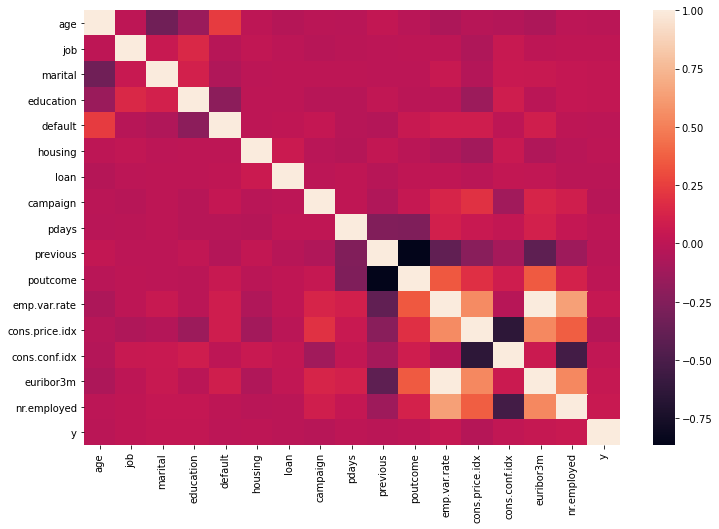

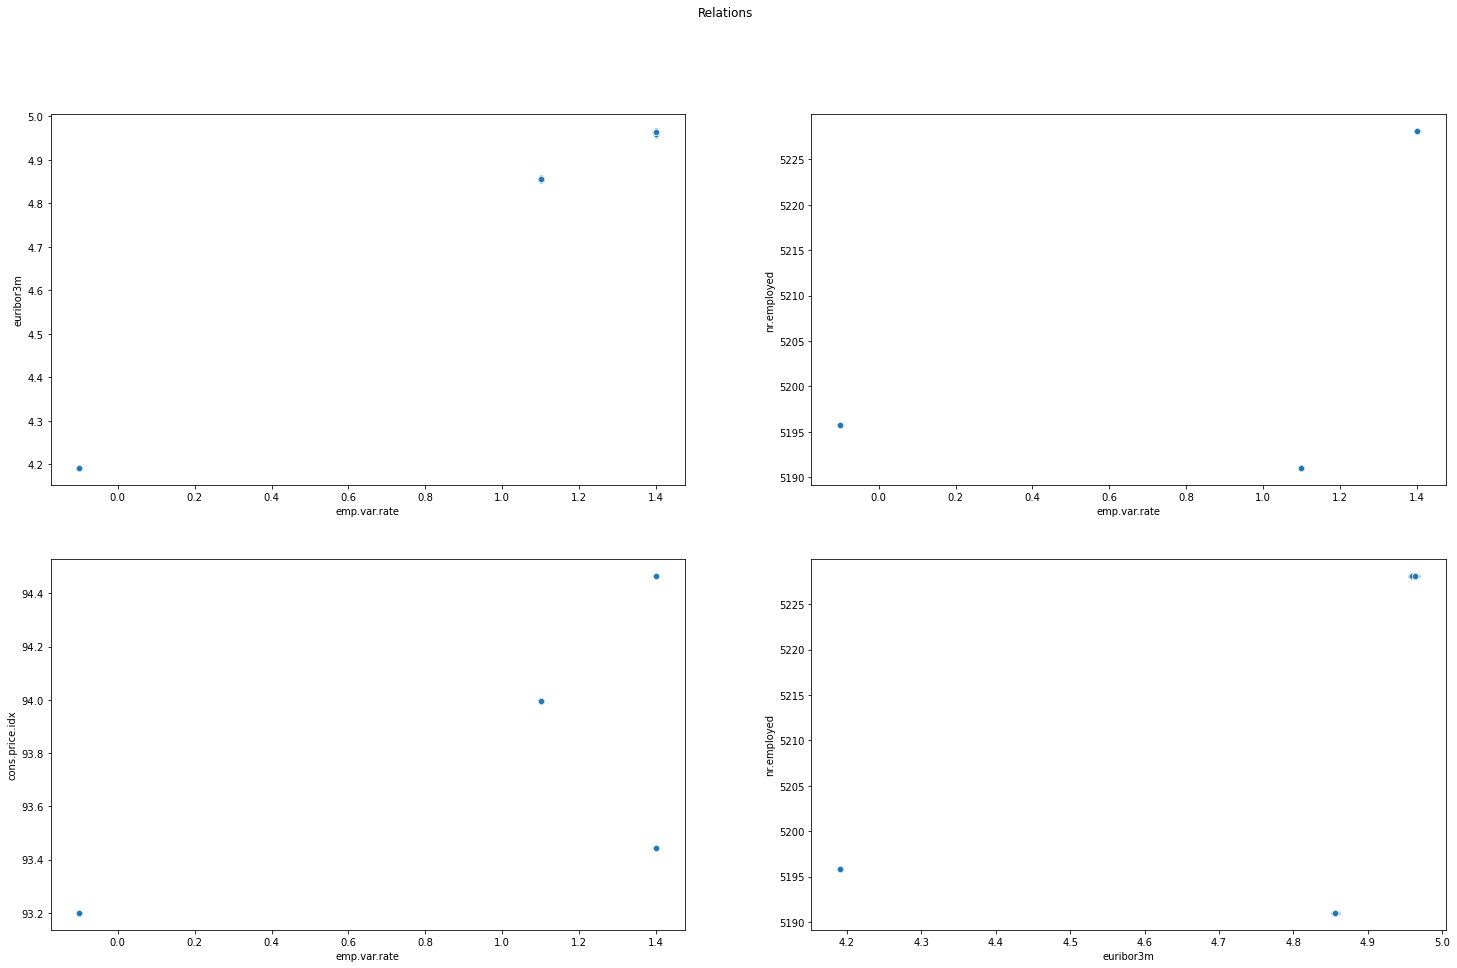

In [12]:
sns_heat(df)

In [13]:
df

,age,job,marital,education,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,45,management,married,university.degree,no,yes,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,34,admin.,married,basic.9y,no,no,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,47,blue-collar,married,unknown,unknown,no,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,42,technician,married,professional.course,no,no,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
4,57,technician,married,basic.4y,unknown,no,yes,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,40,blue-collar,married,basic.9y,no,yes,no,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
4166,37,admin.,married,university.degree,no,no,no,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
4167,32,technician,married,university.degree,no,yes,no,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
4168,38,entrepreneur,married,high.school,no,yes,no,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [14]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    del original_dataframe[feature_to_encode]
    return(res)

In [15]:
df= encode_and_bind(df, "marital")
df= encode_and_bind(df, "loan")
df= encode_and_bind(df, "housing")
df= encode_and_bind(df, "default")
df= encode_and_bind(df, "poutcome")
df= encode_and_bind(df, "job")
del df["loan"]
del df["housing"]
del df["default"]
del df["poutcome"]
del df["job"]
del df["marital"]



In [16]:
df

,age,education,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,45,university.degree,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,0,0,0,0,0
1,34,basic.9y,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,0,0,0,0
2,47,unknown,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,0,0,0,0
3,42,professional.course,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,0,1,0,0
4,57,basic.4y,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,40,basic.9y,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,0,0,0,0,0,0,0
4166,37,university.degree,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,0,0,0,0,0,0,0
4167,32,university.degree,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,0,0,0,0,1,0,0
4168,38,high.school,2,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,1,0,0,0,0,0,0,0,0,0


In [17]:
df["education"].value_counts()

university.degree      1129
high.school             930
basic.9y                671
professional.course     531
basic.4y                489
basic.6y                247
unknown                 173
Name: education, dtype: int64

In [18]:
df['education'].replace(to_replace=['university.degree', "professional.course", 'high.school', 'basic.9y', "basic.6y", "basic.4y", "unknown"], value=[6,5,4,3,2,1,0], inplace=True)

In [19]:
df["y"].replace(to_replace=["yes", "no"], value=[1, 0], inplace=True)

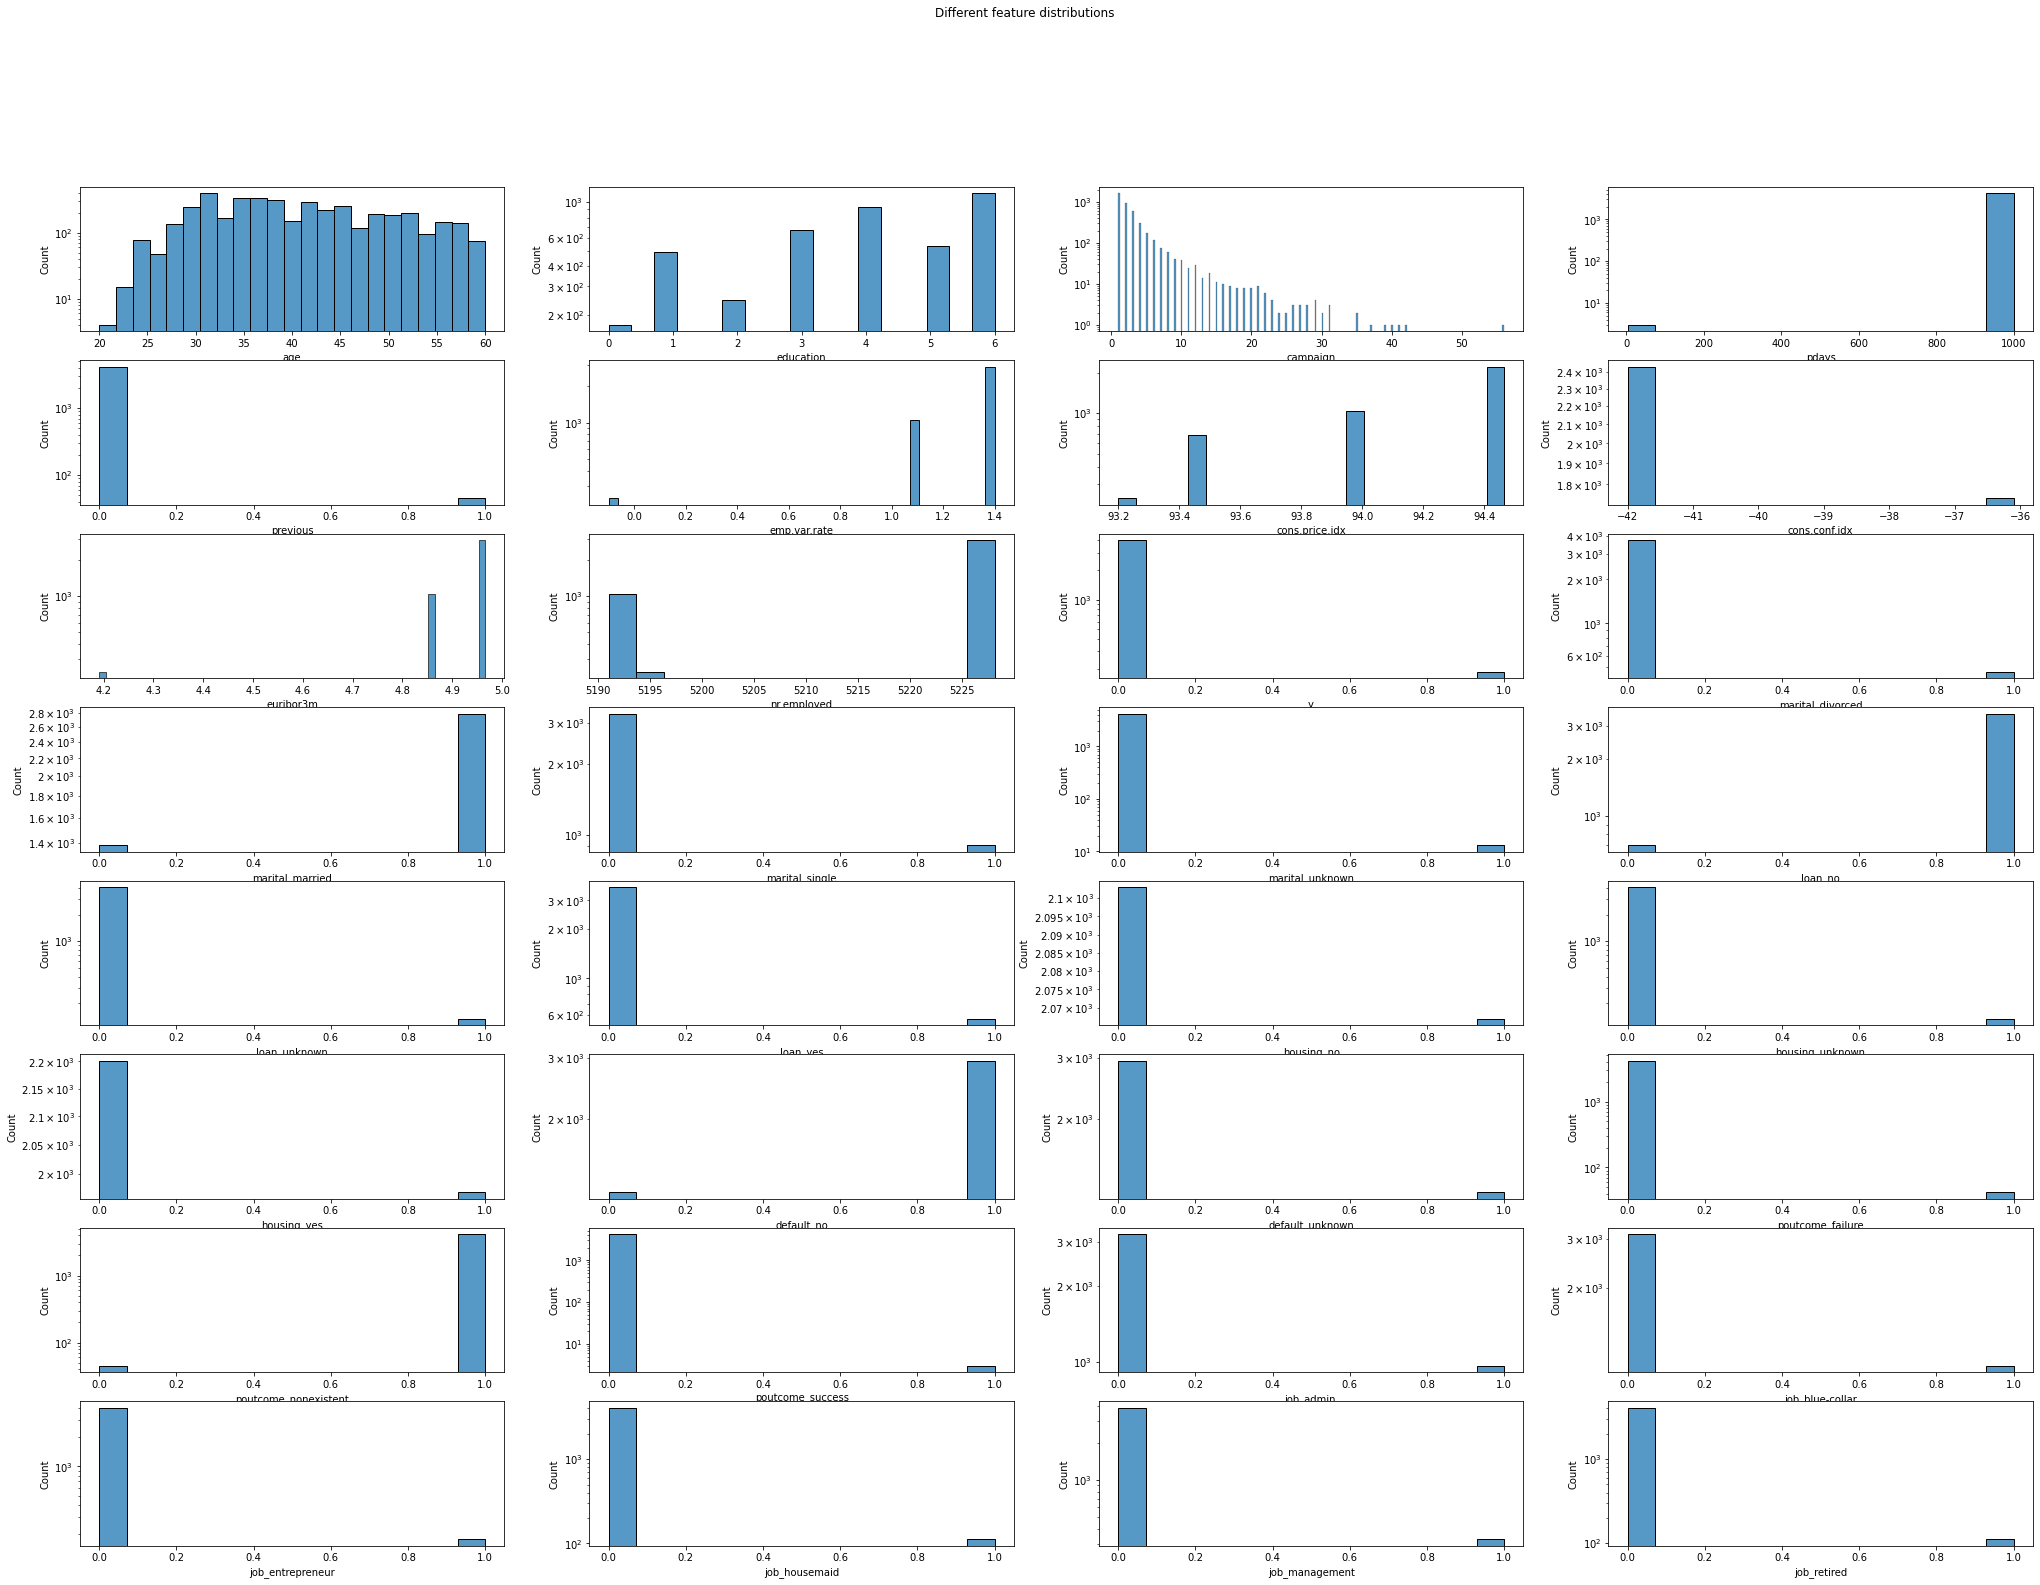

In [20]:
fig, axes = plt.subplots(8, 4, figsize=(35, 25))
fig.suptitle('Different feature distributions')

axes = axes.reshape(32,)

for i,column in enumerate(df.columns):
    kde_status = False
    if i>=32:
        break
    axes[i].set_yscale('log')
    
#     if column == "Time" or column == "Amount":
#         kde_status = True
        
    sns.histplot(ax = axes[i], data = df, x= str(column), kde=kde_status)


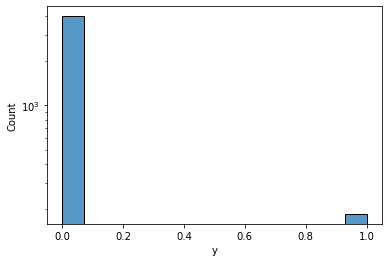

In [21]:
plot = sns.histplot(data = df , x = "y")
plot.set(yscale="log")
print()

<AxesSubplot:>

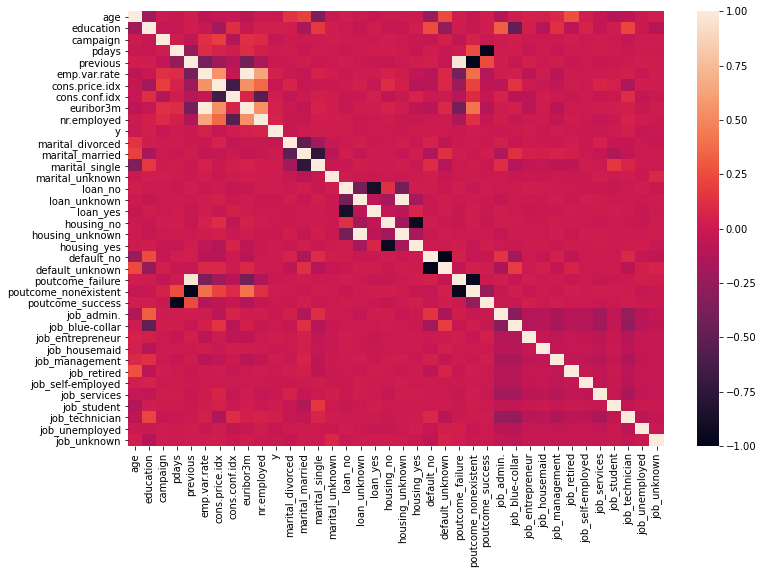

In [22]:
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(df.corr(),axes = ax)

In [23]:
y=df["y"]
del df["y"]

In [24]:
y.head()

0    0
1    0
2    0
3    1
4    0
Name: y, dtype: int64

In [25]:
df

,age,education,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,45,6,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,0,0,0,0,0
1,34,3,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,0,0,0,0
2,47,0,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,0,0,0,0
3,42,5,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,0,1,0,0
4,57,1,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,40,3,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,0,0,0,0,0,0,0
4166,37,6,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,0,0,0,0,0,0,0
4167,32,6,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,0,0,0,0,1,0,0
4168,38,4,2,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,1,0,0,0,0,0,0,0,0,0


In [26]:
from sklearn import preprocessing

In [27]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [28]:
df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.625,1.000000,0.000000,1.0,0.0,0.8,0.627668,0.949153,0.859355,0.00000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.350,0.500000,0.000000,1.0,0.0,0.8,0.627668,0.949153,0.859355,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.675,0.000000,0.000000,1.0,0.0,0.8,0.627668,0.949153,0.859355,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.550,0.833333,0.000000,1.0,0.0,0.8,0.627668,0.949153,0.859355,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.925,0.166667,0.000000,1.0,0.0,0.8,0.627668,0.949153,0.859355,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,0.500,0.500000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.12938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4166,0.425,1.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.12938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4167,0.300,1.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.12938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4168,0.450,0.666667,0.018182,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.12938,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
xtr, xte, ytr, yte = train_test_split(df, y, test_size = 0.2 , shuffle = True, random_state=42)

In [30]:
#Over sampling (SMOTE)

In [31]:
over_X , over_y = SMOTE().fit_resample(df, y)
over_X , over_y = shuffle(over_X,over_y,random_state = 0)

In [32]:
#Under Sampling

In [33]:
under_X , under_y = RandomUnderSampler(random_state=0).fit_resample(df,y)
under_X , under_y = shuffle(under_X,under_y,random_state = 0)

In [34]:
#Building models

In [35]:
#giving weights (panelty)
weights = {0:1.0, 1:15.0}


In [36]:
model1 = LogisticRegression(solver='liblinear')
model2 = DecisionTreeClassifier(max_depth=35, class_weight='balanced', random_state=42)
model3 = SVC()

In [37]:
def build_classifier():
    model = Sequential()

    model.add(Dense(units = 32,kernel_initializer="uniform",activation="relu",input_shape = (37,)))
    model.add(Dense(units = 64,kernel_initializer="uniform",activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units = 32,kernel_initializer="uniform",activation="relu"))
    model.add(Dense(units = 1,kernel_initializer="uniform",activation="sigmoid"))
    
    model.compile(optimizer = "adam",loss="binary_crossentropy",metrics=['Recall'])

    return model

In [38]:
classifier = KerasClassifier(build_fn=build_classifier,batch_size = 256,epochs = 10)

In [39]:
#Cross Validation score - oversampled data

In [40]:
scores = cross_val_score(estimator=model1,X=over_X,y=over_y,cv=5,scoring="f1")
print("Logistic Regression cross validation score : " , np.round(scores.mean()*100,3),"%")
scores = cross_val_score(estimator=model2,X=over_X,y=over_y,cv=10,scoring="f1")
print("Decision Tree cross validation score : " , np.round(scores.mean()*100,3),"%")

Logistic Regression cross validation score :  65.756 %
Decision Tree cross validation score :  94.16 %


In [41]:
scores = cross_val_score(estimator=RandomForestClassifier(max_depth=35),X=over_X,y=over_y,cv=5,scoring="f1")
print("Random Forest cross validation score : " , np.round(scores.mean()*100,3),"%")

Random Forest cross validation score :  97.16 %


In [42]:
scores = cross_val_score(estimator=classifier,X=over_X,y=over_y,cv=5,scoring="f1",n_jobs = 1)

clear_output()

In [43]:
print("ANN cross validation score : " , np.round(scores.mean()*100,3),"%")

ANN cross validation score :  74.354 %


In [44]:
#Undersampled data

In [45]:
scores = cross_val_score(estimator=model1,X=under_X,y=under_y,cv=5,scoring="f1")
print("Logistic Regression cross validation score : " , np.round(scores.mean()*100,3),"%")
scores = cross_val_score(estimator=model2,X=under_X,y=under_y,cv=5,scoring="f1")
print("Decision Tree cross validation score : " , np.round(scores.mean()*100,3),"%")
scores = cross_val_score(estimator=RandomForestClassifier(max_depth=35),X=under_X,y=under_y,cv=5,scoring="f1")
print("Random Forest cross validation score : " , np.round(scores.mean()*100,3),"%")
scores = cross_val_score(estimator=model3,X=under_X,y=under_y,cv=5,scoring="f1")
print("SVC cross validation score : " , np.round(scores.mean()*100,3),"%")

Logistic Regression cross validation score :  55.982 %
Decision Tree cross validation score :  50.488 %
Random Forest cross validation score :  52.078 %
SVC cross validation score :  54.665 %


In [46]:
classifier = KerasClassifier(build_fn=build_classifier,batch_size = 1,epochs = 20)
scores = cross_val_score(estimator=classifier,X=under_X,y=under_y,cv=5,scoring="f1")

clear_output()

In [47]:
print("ANN cross validation score : " , np.round(scores.mean()*100,3),"%")

ANN cross validation score :  57.791 %


In [48]:
#No sampling test train split

In [49]:
# xtr, xte, ytr, yte = train_test_split(df, y, test_size = 0.2 , shuffle = True, random_state=42)

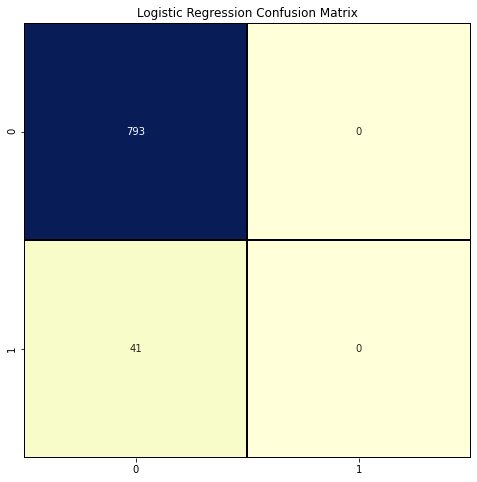

In [50]:
model1.fit(xtr,ytr)


predictions = model1.predict(xte)
conf_matrix = confusion_matrix(yte, predictions)

plt.figure(figsize=(8,8))
ax = plt.axes()
sns.heatmap(conf_matrix,annot=True,fmt='g',cbar=False,axes=ax,cmap ="YlGnBu",linewidths=1,linecolor='black')
ax.set_title('Logistic Regression Confusion Matrix')

plt.show()

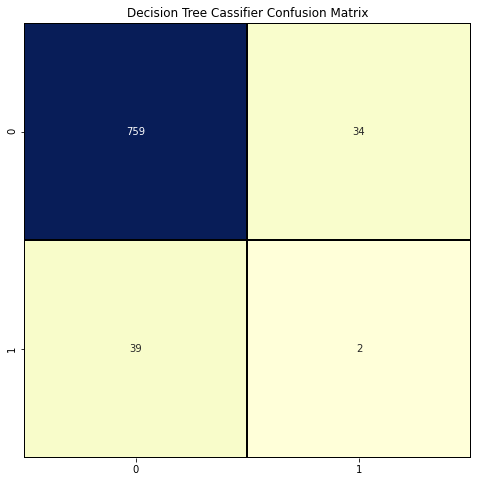

In [61]:
# model2.fit(over_X, over_y)
model2.fit(xtr,ytr)


predictions = model2.predict(xte)
conf_matrix = confusion_matrix(yte, predictions)

plt.figure(figsize=(8,8))
ax = plt.axes()
sns.heatmap(conf_matrix,annot=True,fmt='g',cbar=False,axes=ax,cmap ="YlGnBu",linewidths=1,linecolor='black')
ax.set_title('Decision Tree Cassifier Confusion Matrix')

plt.show()

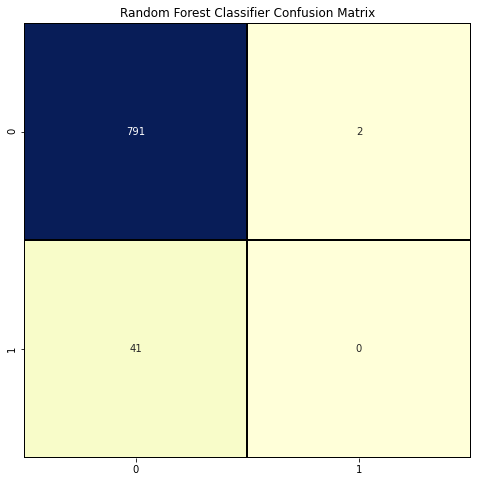

In [52]:
model4 = RandomForestClassifier(max_depth = 35)
model4.fit(xtr,ytr)


predictions = model4.predict(xte)
conf_matrix = confusion_matrix(yte, predictions)

plt.figure(figsize=(8,8))
ax = plt.axes()
sns.heatmap(conf_matrix,annot=True,fmt='g',cbar=False,axes=ax,cmap ="YlGnBu",linewidths=1,linecolor='black')
ax.set_title('Random Forest Classifier Confusion Matrix')

plt.show()

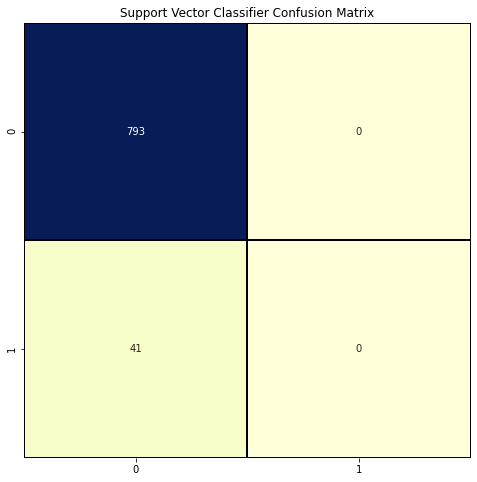

In [53]:
model3.fit(xtr,ytr)


predictions = model3.predict(xte)
conf_matrix = confusion_matrix(yte, predictions)

plt.figure(figsize=(8,8))
ax = plt.axes()
sns.heatmap(conf_matrix,annot=True,fmt='g',cmap ="YlGnBu",cbar=False,axes=ax,linewidths=1,linecolor='black')
ax.set_title('Support Vector Classifier Confusion Matrix')

plt.show()

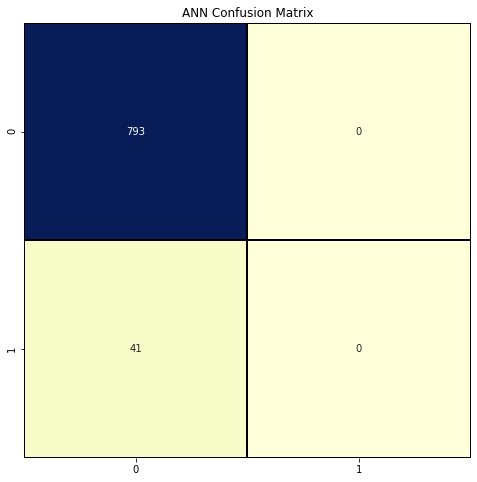

In [54]:
model5 = build_classifier()
# weights = {0:1.0, 1:15.5}
history = model5.fit(xtr,ytr,epochs=20,batch_size=256,shuffle=True)

clear_output()

predictions = (model5.predict(xte) > 0.5).astype('int32').reshape(xte.shape[0],)
conf_matrix = confusion_matrix(yte, predictions)

plt.figure(figsize=(8,8))
ax = plt.axes()
sns.heatmap(conf_matrix,annot=True,fmt='g',cbar=False,axes=ax,cmap ="YlGnBu",linewidths=1,linecolor='black')
ax.set_title('ANN Confusion Matrix')

plt.show()

In [55]:
from sklearn.metrics import accuracy_score

import xgboost as xgb

# Init classifier
xgb_cl = xgb.XGBClassifier()
scores = cross_val_score(estimator=xgb_cl,X=over_X,y=over_y,cv=5,scoring="f1")
clear_output()
print("XGBoost cross validation score : " , np.round(scores.mean()*100,3),"%")


XGBoost cross validation score :  97.329 %


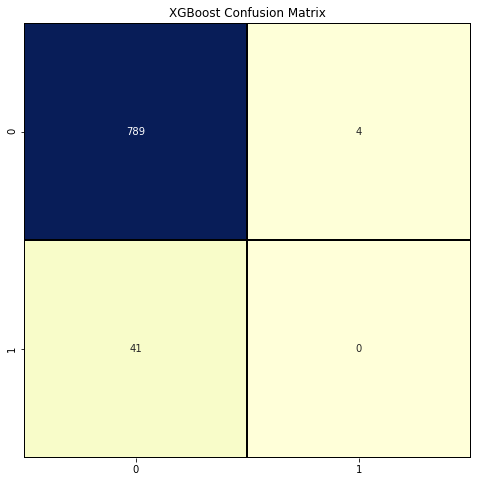

In [56]:
xgb_cl.fit(xtr,ytr)
predictions = xgb_cl.predict(xte)
conf_matrix = confusion_matrix(yte, predictions)

plt.figure(figsize=(8,8))
ax = plt.axes()
sns.heatmap(conf_matrix,annot=True,fmt='g',cmap ="YlGnBu",cbar=False,axes=ax,linewidths=1,linecolor='black')
ax.set_title('XGBoost Confusion Matrix')
clear_output()

plt.show()

In [57]:
#test
df=pd.read_csv("C:/Users/Fakeha Rahman/Downloads/Testing_Dataset_Time_Deposit - Sheet1 (1).csv")

In [58]:
df.head()

,key,age,job,marital,education,default,housing,loan,contact,month,...,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,2,57,services,married,high.school,unknown,no,no,telephone,may,...,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,3,37,services,married,high.school,no,yes,no,telephone,may,...,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,4,40,admin.,married,basic.6y,no,no,no,telephone,may,...,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,5,56,services,married,high.school,no,no,yes,telephone,may,...,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [59]:
del df["duration"]
del df["contact"]
del df["day_of_week"]
del df["month"]
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    del original_dataframe[feature_to_encode]
    return(res)

df= encode_and_bind(df, "marital")
df= encode_and_bind(df, "loan")
df= encode_and_bind(df, "housing")
df= encode_and_bind(df, "default")
df= encode_and_bind(df, "poutcome")
df= encode_and_bind(df, "job")
del df["loan"]
del df["housing"]
del df["default"]
del df["poutcome"]
del df["job"]
del df["marital"]

df['education'].replace(to_replace=['university.degree', "professional.course", 'high.school', 'basic.9y', "basic.6y", "basic.4y", "unknown", "illiterate"], value=[6,5,4,3,2,1,0, 0], inplace=True)
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)